In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Prepare the files

In [4]:
base_dir = '/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project'

for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        print(f'{dirname}/{filename}')

/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/.DS_Store
/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/test1.zip
/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/train.zip


In [5]:
!unzip -q '/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/test1.zip' -d '/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project'
!unzip -q '/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/train.zip' -d '/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project'

In [8]:
for dirname, subdirs, filenames in os.walk(base_dir):
    print(f'Folder: {dirname}')
    if subdirs:
        print(f' Subfolders: {subdirs}')
    if filenames:
        print(f' Files: {filenames[:5]}')  # first 3 files

Folder: /Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project
 Subfolders: ['test1', 'train']
 Files: ['.DS_Store', 'test1.zip', 'train.zip']
Folder: /Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/test1
 Files: ['9733.jpg', '63.jpg', '6400.jpg', '823.jpg', '4217.jpg']
Folder: /Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/train
 Files: ['dog.8011.jpg', 'cat.5077.jpg', 'dog.7322.jpg', 'cat.2718.jpg', 'cat.10151.jpg']


# Prepare Training Data

In [3]:
train_dir = '/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/train/'
filenames = os.listdir(train_dir)
labels = ['dog' if 'dog' in filename else 'cat' for filename in filenames]

df = pd.DataFrame({
    'filename' : filenames,
    'label' : labels
})

df.head()

,filename,label
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


In [4]:
df.tail()

,filename,label
24995,dog.8008.jpg,dog
24996,dog.1992.jpg,dog
24997,dog.12412.jpg,dog
24998,cat.2701.jpg,cat
24999,cat.10148.jpg,cat


## Visualization

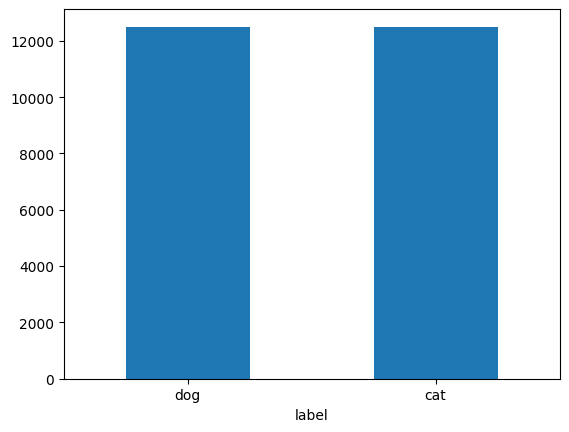

In [5]:
df['label'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.show()

Equal split of both dogs and cats images in training data

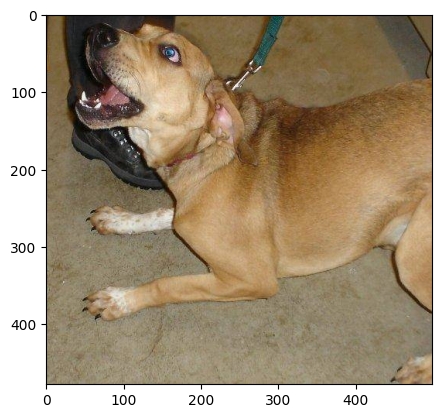

In [6]:
sample = random.choice(filenames)
image = load_img(train_dir+sample)
plt.imshow(image)

# Split Data

In [7]:
# split df into training (80%) & validation (20%) datasets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df['label'])

train_df.shape, val_df.shape

((20000, 2), (5000, 2))

# Build the Image Generator

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

# training generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_dir,
    x_col='filename',
    y_col='label',
    target_size=(150,150),
    class_mode='binary',
    batch_size=32,
)

# validation generator
val_generator = train_datagen.flow_from_dataframe(
    val_df,
    train_dir,
    x_col='filename',
    y_col='label',
    target_size=(150,150),
    class_mode='binary',
    batch_size=32,
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# CNN Model

In [9]:
model = Sequential([
    # layer 1
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    # layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # layer 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Fully connected layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-23 10:39:59.531696: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-10-23 10:39:59.531991: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-23 10:39:59.531995: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-23 10:39:59.532036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-23 10:39:59.532230: I tensorflow/core/common_runtime/pluggable_device/pl

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [10]:
# compiling the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# training the model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-23 10:40:13.757654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 77ms/step - accuracy: 0.6605 - loss: 0.6174 - val_accuracy: 0.7414 - val_loss: 0.5233
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.7483 - loss: 0.5262 - val_accuracy: 0.7848 - val_loss: 0.4556
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.7853 - loss: 0.4676 - val_accuracy: 0.7972 - val_loss: 0.4400
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.8055 - loss: 0.4449 - val_accuracy: 0.7768 - val_loss: 0.5388
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8083 - loss: 0.4674 - val_accuracy: 0.7988 - val_loss: 0.4876
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8123 - loss: 0.5093 - val_accuracy: 0.8200 - val_loss: 0.4816
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8098 - loss: 0.6192 - val_accuracy: 0.8144 - val_loss: 0.6502
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8096 - loss: 0.8110 - val_accurac

# Predictions on Test dataset

In [11]:
# preparing test data
test_dir = '/Users/riddhibajaj/Documents/VS Code/Projects/Image Classification Project/test1/'
filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename':filenames
})

test_df.head()

,filename
0,9733.jpg
1,63.jpg
2,6400.jpg
3,823.jpg
4,4217.jpg


In [12]:
# test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    test_dir,
    x_col='filename',
    y_col=None,
    target_size=(150,150),
    class_mode=None,
    batch_size=32,
    shuffle=False
)

Found 12500 validated image filenames.


In [13]:
# predictions
predictions = model.predict(test_generator, verbose=1)

test_df['probability'] = predictions
test_df['predicted_label'] = ['dog' if prediction > 0.5 else 'cat' for prediction in predictions]

test_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step


,filename,probability,predicted_label
0,9733.jpg,1.816891e-21,cat
1,63.jpg,4.853222e-16,cat
2,6400.jpg,9.999945e-01,dog
3,823.jpg,1.000000e+00,dog
4,4217.jpg,3.366077e-07,cat


# Visualize Predictions

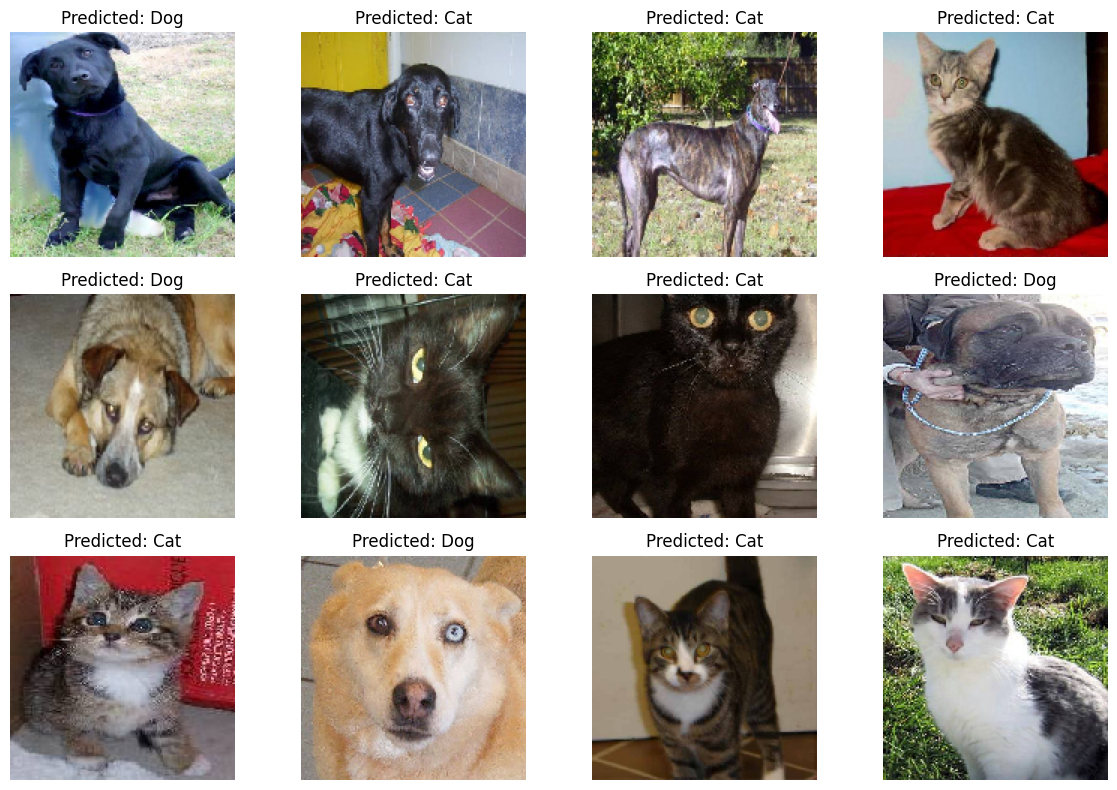

In [14]:
sample = test_df.sample(12)

plt.figure(figsize=(12,8))
for i, row in enumerate(sample.itertuples()):
    image = load_img(f'{test_dir}/{row.filename}', target_size=(150,150))
    plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(f'Predicted: {row.predicted_label.title()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save Model

In [15]:
model.save('image_classifier_model.h5')